__Author: Peter Kicsiny__

Tested with Xsuite versions:
- xobjects: 0.4.5 
- xtrack: 0.70.3 
- xfields: 0.21.3 
- xpart: 0.19.3

In [1]:
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['figure.subplot.left'] = 0.18
matplotlib.rcParams['figure.subplot.bottom'] = 0.16
matplotlib.rcParams['figure.subplot.right'] = 0.92
matplotlib.rcParams['figure.subplot.top'] = 0.9
matplotlib.rcParams['figure.figsize'] = (12,8)
import time

print(xo.__version__, xt.__version__, xf.__version__, xp.__version__)

0.4.5 0.70.3 0.21.3 0.19.3


In [74]:
bunch_intensity     = 1.55e11  # [1]
energy              = 182.5  # [GeV]
p0c                 = energy*1e9  # [eV]
mass0               = 511000  # [eV]
phi                 = 15e-3  # [rad] half xing
u_sr                = 10.42  # [GeV]
qx                  = 0.537  # [1] superperiod tune
qy                  = 0.546  # [1]
qs                  = 0.02275  # [1]
physemit_x          = 1.59e-09  # [m]
physemit_y          = 9e-13  # [m]
beta_x              = 1  # [m]
beta_y              = 1.6e-3  # [m]
sigma_x             = np.sqrt(physemit_x*beta_x)  # [m]
sigma_px            = np.sqrt(physemit_x/beta_x)  # [1]
sigma_y             = np.sqrt(physemit_y*beta_y)  # [m]
sigma_py            = np.sqrt(physemit_y/beta_y)  # [1]
sigma_z             = 1.81e-3  # [m] sr
sigma_z_bs          = 2.17e-3  # [m] sr+bs
sigma_delta         = 16e-4  # [1]
sigma_delta_bs      = 19.2e-4  # [1] sr+bs
beta_s              = sigma_z/sigma_delta  # [m]
physemit_s          = sigma_z*sigma_delta  # [m]
physemit_s_bs       = sigma_z_bs*sigma_delta_bs  # [m]
n_ip                = 4  # [1]
k2_factor = 0.4  # [1] crab-waist strength scaling factor
phi = 15e-3  # [rad] half crossing angle

n_turns = 500

Here we define 10000 macroparticles for both bunches. With stron-strong simulations the statistical convergence requires to use a sufficient amount of macroparticles per longitudinal slice. Currently 21 macroparticles per slice is defined as a minimum in Xsuite. If a slice contains 20 or less macroparticles, the beam-beam force asserted by that slice on the opposite bunch is not calculated.

In [75]:
n_macroparticles_b1 = int(1e4)
n_macroparticles_b2 = n_macroparticles_b1

The context defines the platform. The platform can be thought of as the execution environment, such as a CPU with a given amount of threads or a GPU using a given programming interface such as CUDA or OpenCL.

In [76]:
context = xo.ContextCpu(omp_num_threads=8)

We define an electron beam with 1000 macroparticles with initial distributions characterized by the variables `*_init`. We also define the equilibrium parameters denoted by the variables `*_eq`. All of these can be defined arbitrarily but here we use the nominal equilibrium numbers from the reference.

In [124]:
# initial beam sizes
(sigma_x_init, sigma_y_init, sigma_z_init,
 sigma_px_init, sigma_py_init, sigma_delta_init,
 physemit_x_init, physemit_y_init, physemit_s_init) = (     sigma_x,      sigma_y,      sigma_z, 
                                                           sigma_px,     sigma_py,  sigma_delta, 
                                                       physemit_x, physemit_y, physemit_s
                                                      )
# synrad equilibrium beam sizes
(sigma_x_eq, sigma_y_eq, sigma_z_eq, 
 sigma_px_eq, sigma_py_eq, sigma_delta_eq, 
 physemit_x_eq, physemit_y_eq, physemit_s_eq) = (   sigma_x,    sigma_y,     sigma_z,
                                                   sigma_px,   sigma_py, sigma_delta,
                                                 physemit_x, physemit_y,  physemit_s
                                                )

(sigma_z_eq_bs, sigma_delta_eq_bs, physemit_s_eq_bs) = (sigma_z_bs, sigma_delta_bs, physemit_s_bs)

# for reproducibility fix the random seed
np.random.seed(2)

# this is an electron beam
particles_b1 = xp.Particles(
            _context = context, 
            q0        = -1,
            p0c       = p0c,
            mass0     = mass0,
            x         = sigma_x_init        *np.random.randn(n_macroparticles_b1),
            y         = sigma_y_init        *np.random.randn(n_macroparticles_b1),
            zeta      = sigma_z_init        *np.random.randn(n_macroparticles_b1),
            px        = sigma_px_init       *np.random.randn(n_macroparticles_b1),
            py        = sigma_py_init       *np.random.randn(n_macroparticles_b1),
            delta     = sigma_delta_init    *np.random.randn(n_macroparticles_b1),
            weight=bunch_intensity/n_macroparticles_b1
)

# this is a positron beam
particles_b2 = xp.Particles(
            _context = context, 
            q0        = 1,
            p0c       = p0c,
            mass0     = mass0,
            x         = sigma_x_init    *np.random.randn(n_macroparticles_b2),
            y         = sigma_y_init    *np.random.randn(n_macroparticles_b2),
            zeta      = sigma_z_init    *np.random.randn(n_macroparticles_b2),
            px        = sigma_px_init   *np.random.randn(n_macroparticles_b2),
            py        = sigma_py_init   *np.random.randn(n_macroparticles_b2),
            delta     = sigma_delta_init*np.random.randn(n_macroparticles_b2),
            weight=bunch_intensity/n_macroparticles_b2
            )


Now let's define the accelerator as a linear transfer map, with effective synchrotron radiation. Effective synchrotron radiation means exponential damping + Gaussian random noise excitation applied to each particle. In a more realistic "quantum" synchrotron radiation model instead each particle undergoes random photon emission with energy drawn from a distribution function. The Xsuite `LineSegmentMap` object takes in the damping rates and random noise amplitudes of the RMS bunch size. This can be obtained by halving the damping rate and noise amplitude of the emittance.

In [125]:
emit_damping_rate_s  = 2 * u_sr / energy / n_ip
emit_damping_rate_x = emit_damping_rate_s/2
emit_damping_rate_y = emit_damping_rate_s/2
sigma_damping_rate_s =  emit_damping_rate_s / 2
sigma_damping_rate_x = sigma_damping_rate_s / 2
sigma_damping_rate_y = sigma_damping_rate_s / 2

The optical functions (alpha and beta) at the location of the crab sextupoles can be chosen somewhat arbitrarily. Here I chose `alpha_sext` to be 0 and `beta_y_sext` a large number and `beta_x_sext` a small number. In general as long as `beta_x_sext` is small, there is a freedom to choose `beta_y_sext`. Similarly, as long as `beta_y_sext` is large, there is a freedom to choose `beta_x_sext`. This information is inherited from D. Shatilov and it is arbitrary. The radiation is only set up in the middle arc segment. The crucial part is the setup of the phase advances in `qx` and `qy` such that it corresponds to the crab-waist scheme.

Here there are 6 elements in total, 3 for each beam. The order in which the first (e-) beam will go is: 
`el_arc_left_b1`, `el_arc_mid_b1`, `el_arc_right_b1`. The second (e+) beam will go in the opposite direction which is represented by the sequence: `el_arc_right_b2`, `el_arc_mid_b2`, `el_arc_left_b2`. These are all line segment maps.

In [126]:
beta_x_sext_left  = 3
beta_y_sext_left  = 500
beta_x_sext_right = 3
beta_y_sext_right = 500

alpha_x_sext_left  = 0
alpha_y_sext_left  = 0
alpha_x_sext_right = 0
alpha_y_sext_right = 0

# from IP to right crab sextupole (sy2r.2)
el_arc_left_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x, beta_x_sext_left],
    bety = [beta_y, beta_y_sext_left],
    alfx = [0, alpha_x_sext_left],
    alfy = [0, alpha_y_sext_left],
    bets = beta_s,
)

el_arc_mid_b1 = xt.LineSegmentMap(_context=context,
    qx =  qx, 
    qy =  qy -.5 , # subtract .25*2 phase advance from small arcs
    qs =  qs,
    betx = [beta_x_sext_left, beta_x_sext_right],
    bety = [beta_y_sext_left, beta_y_sext_right],
    alfx = [alpha_x_sext_left, alpha_x_sext_right],
    alfy = [alpha_y_sext_left, alpha_y_sext_right],
    bets = beta_s,
    damping_rate_x     = sigma_damping_rate_x,
    damping_rate_px    = sigma_damping_rate_x,
    damping_rate_y     = sigma_damping_rate_y,
    damping_rate_py    = sigma_damping_rate_y,
    damping_rate_zeta  = sigma_damping_rate_s,
    damping_rate_pzeta = sigma_damping_rate_s,
                                  
    # noise has to be normalized to beamsize at exit using beta at exit!
    gauss_noise_ampl_x     = np.sqrt(physemit_x_eq*beta_x_sext_right) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_px    = np.sqrt(physemit_x_eq/beta_x_sext_right) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_y     = np.sqrt(physemit_y_eq*beta_y_sext_right) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_py    = np.sqrt(physemit_y_eq/beta_y_sext_right) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_zeta  =     sigma_z_eq * np.sqrt(emit_damping_rate_s),
    gauss_noise_ampl_pzeta = sigma_delta_eq * np.sqrt(emit_damping_rate_s),
)

# from left crab sextupole to IP2 (sy2l.1)
el_arc_right_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x_sext_right, beta_x],
    bety = [beta_y_sext_right, beta_y],
    alfx = [alpha_x_sext_right, 0],
    alfy = [alpha_y_sext_right, 0],
    bets = beta_s,
)

el_arc_left_b2 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x_sext_left, beta_x],
    bety = [beta_y_sext_left, beta_y],
    alfx = [alpha_x_sext_left, 0],
    alfy = [alpha_y_sext_left, 0],
    bets = beta_s,
)

el_arc_mid_b2 = xt.LineSegmentMap(_context=context,
    qx =  qx, 
    qy =  qy - 0.5, # subtract .25*2 phase advance from small arcs
    qs =  qs,
    betx = [beta_x_sext_right, beta_x_sext_left],
    bety = [beta_y_sext_right, beta_y_sext_left],
    alfx = [alpha_x_sext_right, alpha_x_sext_left],
    alfy = [alpha_y_sext_right, alpha_y_sext_left],
    bets = beta_s,
    damping_rate_x     = sigma_damping_rate_x,
    damping_rate_px    = sigma_damping_rate_x,
    damping_rate_y     = sigma_damping_rate_y,
    damping_rate_py    = sigma_damping_rate_y,
    damping_rate_zeta  = sigma_damping_rate_s,
    damping_rate_pzeta = sigma_damping_rate_s,
                                  
    # noise has to be normalized to beamsize at exit using beta at exit!
    gauss_noise_ampl_x     = np.sqrt(physemit_x_eq*beta_x_sext_left) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_px    = np.sqrt(physemit_x_eq/beta_x_sext_left) * np.sqrt(emit_damping_rate_x),
    gauss_noise_ampl_y     = np.sqrt(physemit_y_eq*beta_y_sext_left) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_py    = np.sqrt(physemit_y_eq/beta_y_sext_left) * np.sqrt(emit_damping_rate_y),
    gauss_noise_ampl_zeta  =     sigma_z_eq * np.sqrt(emit_damping_rate_s),
    gauss_noise_ampl_pzeta = sigma_delta_eq * np.sqrt(emit_damping_rate_s),
)

el_arc_right_b2 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x, beta_x_sext_right],
    bety = [beta_y, beta_y_sext_right],
    alfx = [0, alpha_x_sext_right],
    alfy = [0, alpha_y_sext_right],
    bets = beta_s,
)

Define the crab-sextupole elements that suppress transverse resonances. Without these the beam would blow up in the vertical size due to the strong vertical beam-beam force.

In [127]:
k2_left  = k2_factor / (2 * phi * beta_y * beta_y_sext_left ) * np.sqrt(beta_x / beta_x_sext_left )
k2_right = k2_factor / (2 * phi * beta_y * beta_y_sext_right) * np.sqrt(beta_x / beta_x_sext_right)

el_sextupole_left_b1  = xt.Multipole(order=2, knl=[0, 0,   k2_left])
el_sextupole_right_b1 = xt.Multipole(order=2, knl=[0, 0, -k2_right])
el_sextupole_left_b2  = xt.Multipole(order=2, knl=[0, 0,   k2_left])
el_sextupole_right_b2 = xt.Multipole(order=2, knl=[0, 0, -k2_right])

For a strong-strong simulation the statistical moments of the slices will be computed based on the actual bunch distributions. Both bunches need to be aware of the moments of the other bunch therefore these moments need to be communicated between the two beam-beam elements. This is required because in Xsuite one beam has an associated beam-beam element and we have no access to the macroparticles of both colliding bunches.

In [128]:
n_slices = 30
slicer = xf.TempSlicer(_context=context, n_slices=n_slices, sigma_z=sigma_z_bs, mode="shatilov")

{'digitize': <xobjects.context.Kernel object at 0x115130250>, 'compute_slice_moments': <xobjects.context.Kernel object at 0x1151304c0>, 'compute_slice_moments_cuda_sums_per_slice': <xobjects.context.Kernel object at 0x115130790>, 'compute_slice_moments_cuda_moments_from_sums': <xobjects.context.Kernel object at 0x115130940>}
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Note below the attribute `quasistrongstrong`. If this is true then quasi-strong-strong model is enabled. This means that the statistical moments of the longitudinal slices are recomputed at the beginning of each collision but not during the collision. If this is set to false we do a full strong-strong simulation in which these moments are recomputed after each timestep during the collision. The quasi-strong-strong model is much faster so I enable it in this example. For the beam-beam element we use the same python object we used in the WS simulation but note that now we don't pass in hardcoded sigmas.

In [129]:
################################################################################
# the pipeline manager enables the communication of data between the two beams #
################################################################################

# identify the two beams as b1 and b2
particles_b1.init_pipeline('b1')
particles_b2.init_pipeline('b2')

# set up pipeline manager (needed for any simulations with communication between the two beams)
pipeline_manager = xt.PipelineManager()
pipeline_manager.add_particles('b1',0)
pipeline_manager.add_particles('b2',0)

# the communication of data (=the stat. moments) takes place at the element named IP1
pipeline_manager.add_element('IP1')

###########################################################
# config file needed as an input to the beambeam elements #
###########################################################

# this goes to bbeamIP1_b1
config_for_update_b1_IP1=xf.ConfigForUpdateBeamBeamBiGaussian3D(
   pipeline_manager=pipeline_manager,
   element_name='IP1',
   partner_particles_name = 'b2',
   slicer=slicer,
   update_every=100,
   quasistrongstrong=True,
   )

# this goes to bbeamIP1_b2
config_for_update_b2_IP1=xf.ConfigForUpdateBeamBeamBiGaussian3D(
   pipeline_manager=pipeline_manager,
   element_name='IP1',
   partner_particles_name = 'b1',
   slicer=slicer,
   update_every=100,
   quasistrongstrong=True,
   )

#################################
# define the beam-beam elements #
#################################

bbeamIP1_b1 = xf.BeamBeamBiGaussian3D(
        _context=context,
    
        ########################################################################
        # this is the charge in units of elementary charges of the strong beam #
        ########################################################################
    
        other_beam_q0 = particles_b2.q0,

        ##################################################################
        # phi=crossing angle in radians, alpha=crossing plane in radians #
        ##################################################################
    
        phi = phi, 
        alpha=0,
    
        ##########################################################################################
        # the config object enabling the communication of moments to the other beam-beam element #
        ##########################################################################################
    
        config_for_update = config_for_update_b1_IP1,
    
        ########################################
        # record luminosity per bunch crossing #
        ########################################
    
        flag_luminosity=1,
)

bbeamIP1_b2 = xf.BeamBeamBiGaussian3D(
        _context=context,

        ########################################################################
        # this is the charge in units of elementary charges of the strong beam #
        ########################################################################
    
        other_beam_q0 = particles_b1.q0,
    
        ##################################################################
        # phi=crossing angle in radians, alpha=crossing plane in radians #
        ##################################################################
    
        phi = -phi, # -phi for beam 2!!!!
        alpha=0,

        ##########################################################################################
        # the config object enabling the communication of moments to the other beam-beam element #
        ##########################################################################################
    
        config_for_update = config_for_update_b2_IP1,
    
        ########################################
        # record luminosity per bunch crossing #
        ########################################
    
        flag_luminosity=1,
)

Another important thing is to set the `phi` attriubte of the beam-beam element of beam 2 to the negative crossing angle. This is because the reference frames, notably the `x` and `s` axes of the two beams point in the opposite dimension.

Here we will have 4 monitors: one at the IP and one outside crab-waist region, and 2 for each beam. At this point the monitors will take up a lot of memory space so it is best to move to a HPC cluster when doing strong-strong studies with a monitor.

In [130]:
monitor_coords_b1_1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,1000))
monitor_coords_b2_1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,1000))
monitor_coords_b1_2 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,1000))
monitor_coords_b2_2 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,1000))

Next we build the accelerator model which means that the underlying C code corresponding to the elements in the accelerator line gets compiled. We need two lines, one for each beam. Note the ordering of the elements in each line. Tracking will begin upstream of the crab-sextupole. To account for the opposite circulation of the two beams, the left arc comes first for beam 1, while the right arc comes first for beam 2.

In [131]:
line_b1 = xt.Line(elements = [
                              monitor_coords_b1_1,
                              bbeamIP1_b1,
                              el_arc_left_b1,
                              el_sextupole_left_b1,
                              el_arc_mid_b1,
                              monitor_coords_b1_2,
                              el_sextupole_right_b1,
                              el_arc_right_b1,

])

line_b2 = xt.Line(elements = [
                              monitor_coords_b2_1,
                              bbeamIP1_b2,
                              el_arc_right_b2,
                              el_sextupole_right_b2,
                              el_arc_mid_b2,
                              monitor_coords_b2_2,
                              el_sextupole_left_b2,
                              el_arc_left_b2,
])


line_b1.build_tracker(_context=context)
line_b2.build_tracker(_context=context)


Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Configure the radiation model. For synchrotron radiation we still use the effective model in the arc element, so we set `model=None`. For beamstrahlung we will use the quantum model with the actual modeling of the photon quantum emission with the beamstrahlung energy distribution, so we set `model_beamstrahlung="quantum"`.

This also initializes the random number generator of the particle object, so we don't need to do `particles_b1._init_random_number_generator()` manually.

In [132]:
assert line_b1._needs_rng == False
line_b1.configure_radiation(model=None, model_beamstrahlung='quantum')
line_b2.configure_radiation(model=None, model_beamstrahlung='quantum')
assert line_b1._needs_rng == True

When tracking 2 beams we need to define a multitracker object and pass in the 2 lines as "branches", with the corresponding beam they will track.

In [133]:
branch_b1 = xt.PipelineBranch(line_b1, particles_b1)
branch_b2 = xt.PipelineBranch(line_b2, particles_b2)
multitracker = xt.PipelineMultiTracker(branches=[branch_b1, branch_b2])

Initialize a buffer (record table) for storung the turn-by-turn luminosity per bunch crossing in unit of [m^-2].

In [134]:
record_b1 = line_b1.start_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D,
                                                      capacity={
                                                          "beamstrahlungtable": int(0),
                                                          "bhabhatable": int(0),
                                                          "lumitable": n_turns,
                                                      })

record_b2 = line_b2.start_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D,
                                                      capacity={
                                                          "beamstrahlungtable": int(0),
                                                          "bhabhatable": int(0),
                                                          "lumitable": n_turns,
                                                      })

Track the 1000 particles for 500 turns with effective synchrotron radiation and with beam-beam in the strong-strong model. Here I track in a for loop to measure the elapsed time per turn.

In [135]:
prev_time = time.time()
for i in range(n_turns):
    multitracker.track(num_turns=1)
    curr_time = time.time()
    if not i%10:
        print(f"Turn [{i+1}/{n_turns}] took: {curr_time-prev_time} [s]")
    prev_time = curr_time

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Turn [1/500] took: 19.167526245117188 [s]
Turn [11/500] took: 0.17183279991149902 [s]
Turn [21/500] took: 0.10783910751342773 [s]
Turn [31/500] took: 0.20250916481018066 [s]
Turn [41/500] took: 0.20586681365966797 [s]
Turn [51/500] took: 0.19899892807006836 [s]
Turn [61/500] took: 0.22751712799072266 [s]
Turn [71/500] took: 0.19895195960998535 [s]
Turn [81/500] took: 0.1920609474182129 [s]
Turn [91/500] took: 0.3111591339111328 [s]
Turn [101/500] took: 0.24103498458862305 [s]
Turn [111/500] took: 0.21077704429626465 [s]
Turn [121/500] took: 0.2575531005859375 [s]
Turn [131/500] took: 0.2120199203491211 [s]
Turn [141/500] took: 0.2014620304107666 [s]
Turn [151/500] took: 0.19384980201721191 [s]
Turn [161/500] took: 0.21035289764404297 [s]
Turn [171/500] took: 0.3276638984680176 [s]
Turn [181/500] took: 0.22938799858093262 [s]
Turn [191/500] took: 0.210601806640625 [s]
Turn [201/500] took: 0.3438737392425537 [s]
Turn [211/500] took: 0.24948883056640625 

Stop the recording of luminosity.

In [136]:
line_b1.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)
line_b2.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)

# lumi [m^-2]
piwi    = sigma_z_bs / sigma_x * phi  # [1] 
lumi_ip = bunch_intensity**2 / (4*np.pi*sigma_x*np.sqrt(1 + piwi**2)*sigma_y)  # [m^-2] for 1 IP
lumi_ip

np.float64(9.787913427915868e+32)

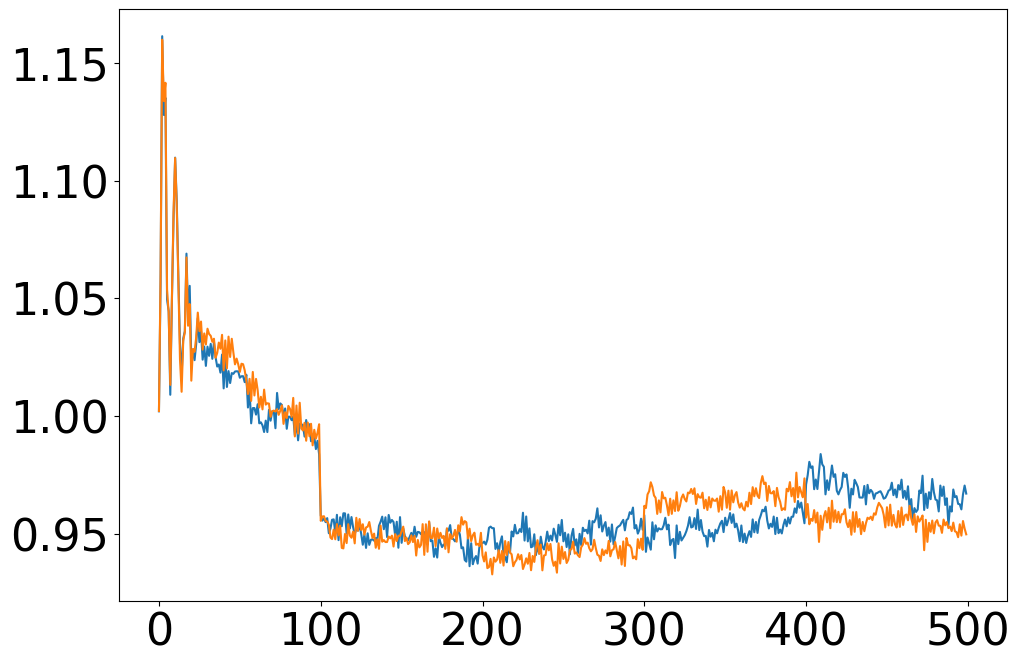

In [146]:
plt.plot(record_b1.lumitable.luminosity/lumi_ip)
plt.plot(record_b2.lumitable.luminosity/lumi_ip)

Now we retrieve the data from the monitor, calculate the emittances and RMS beam sizes and plot them against the number of tracking iterations.

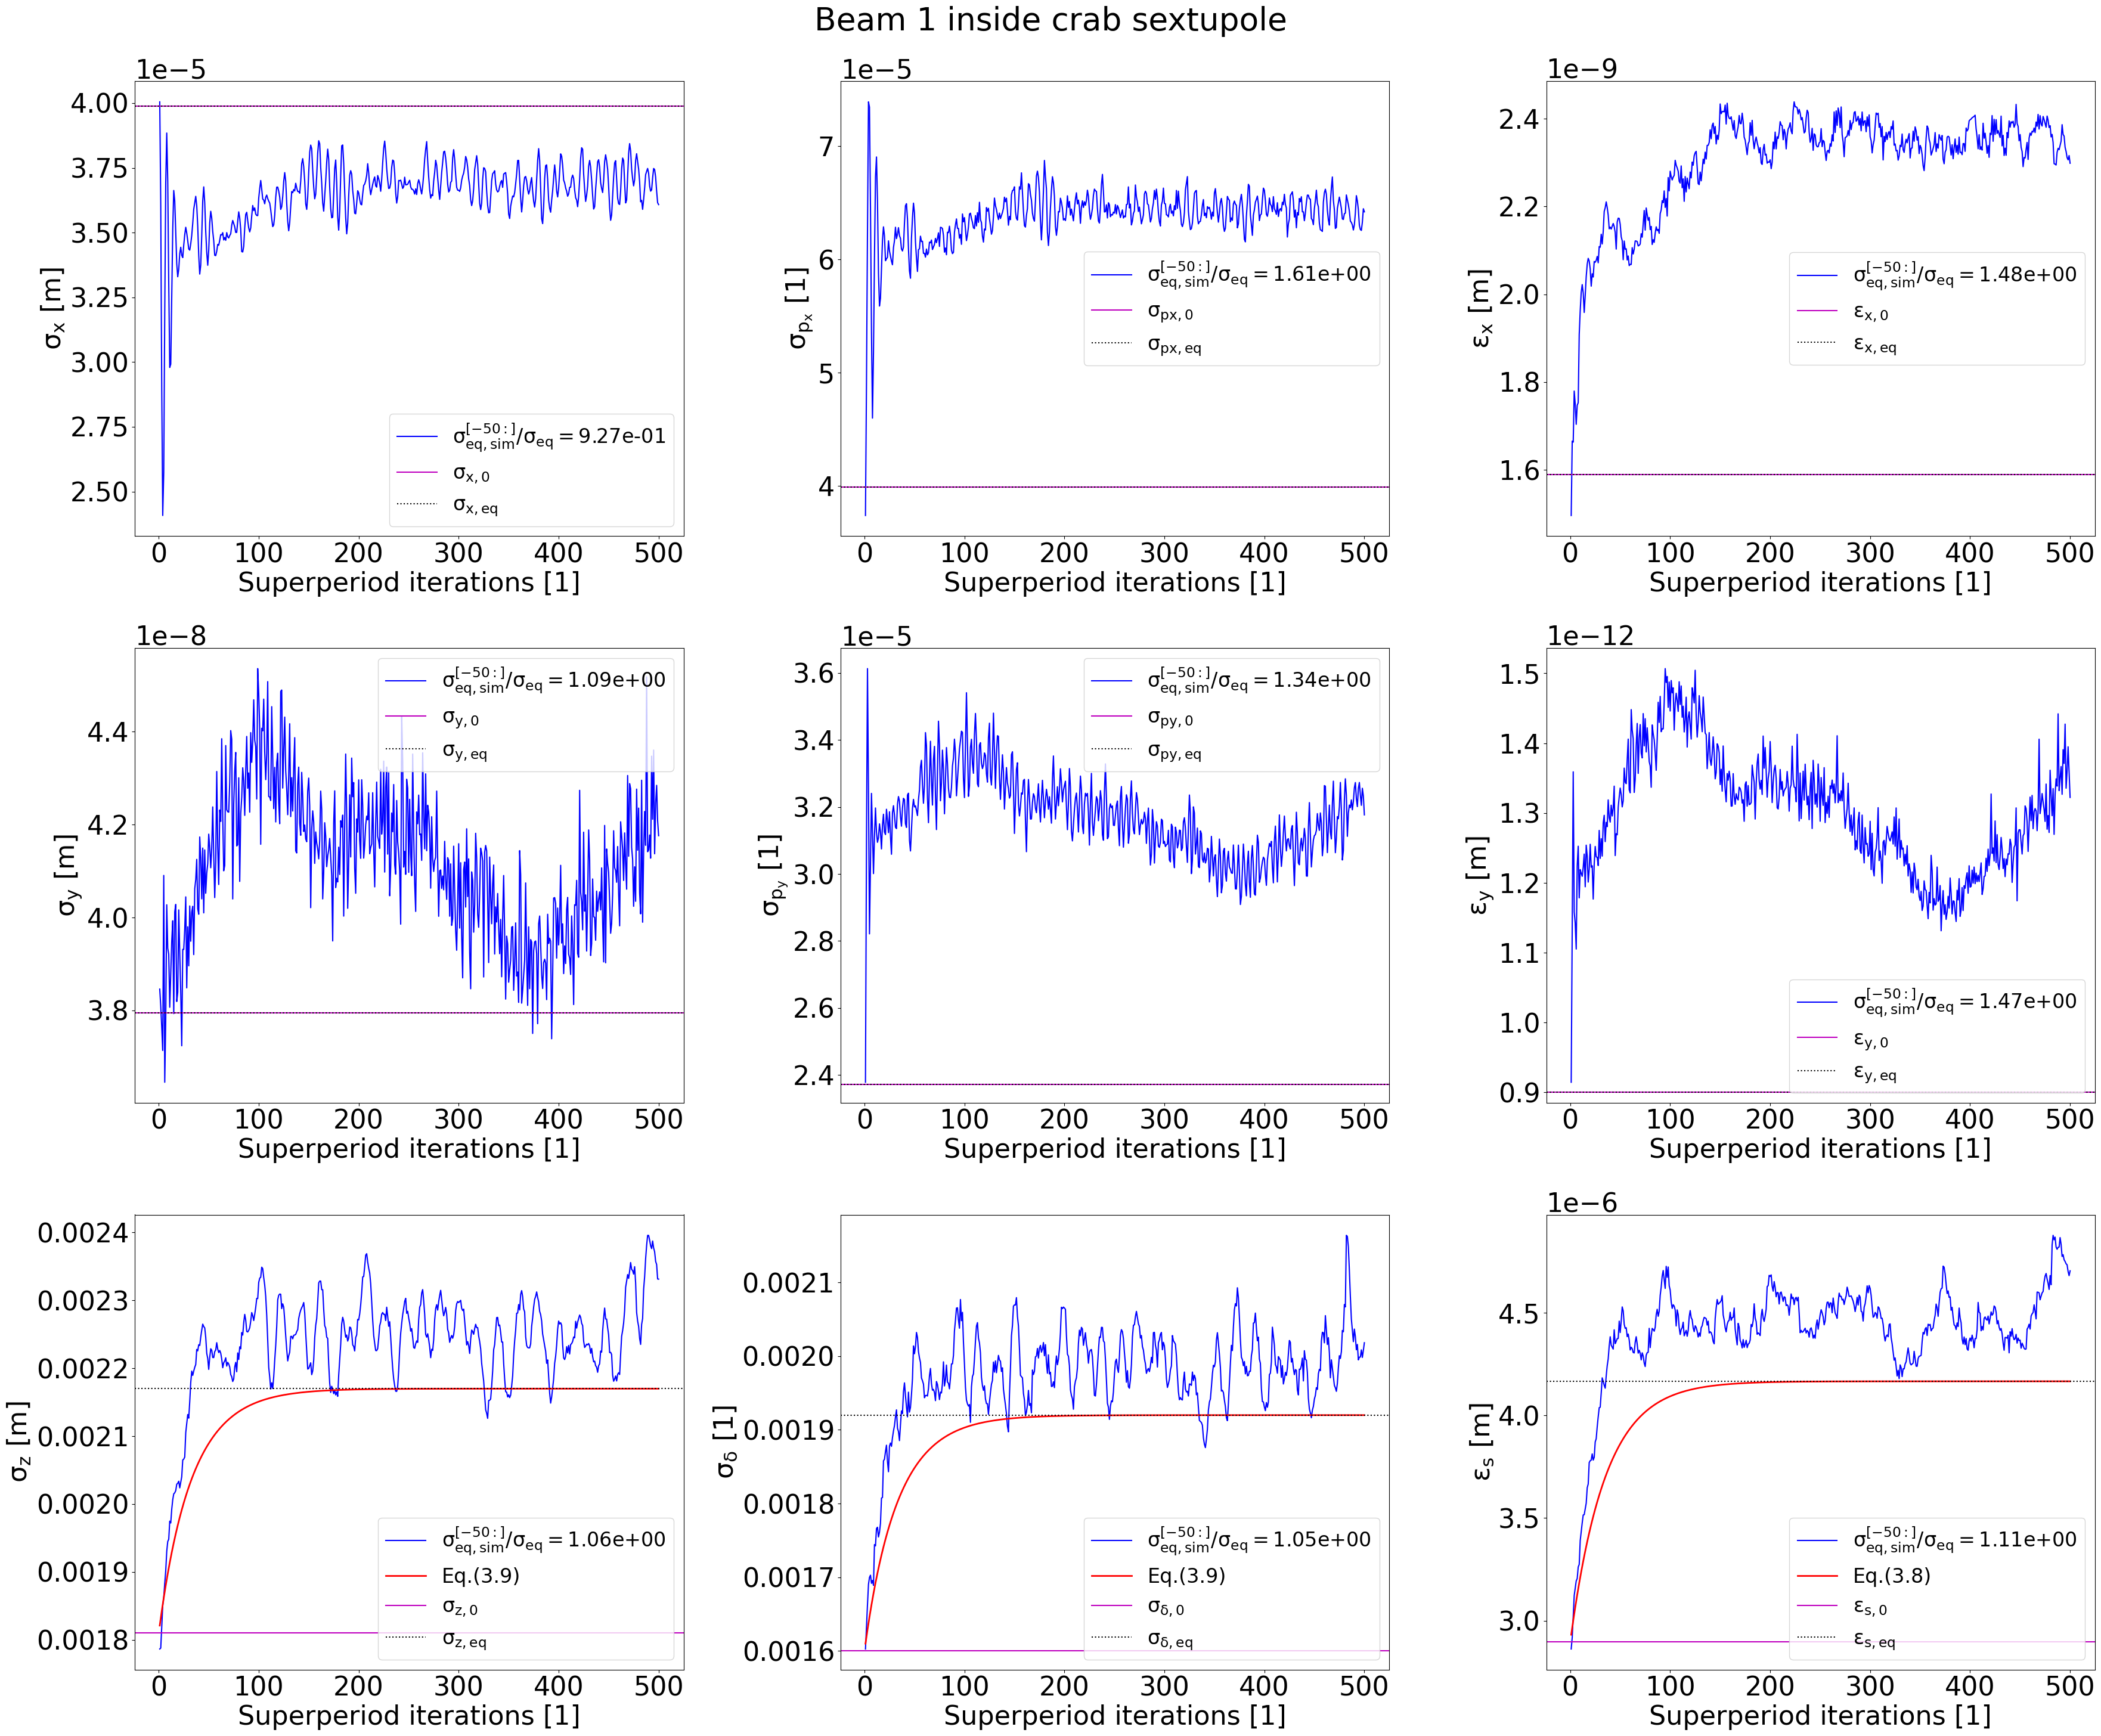

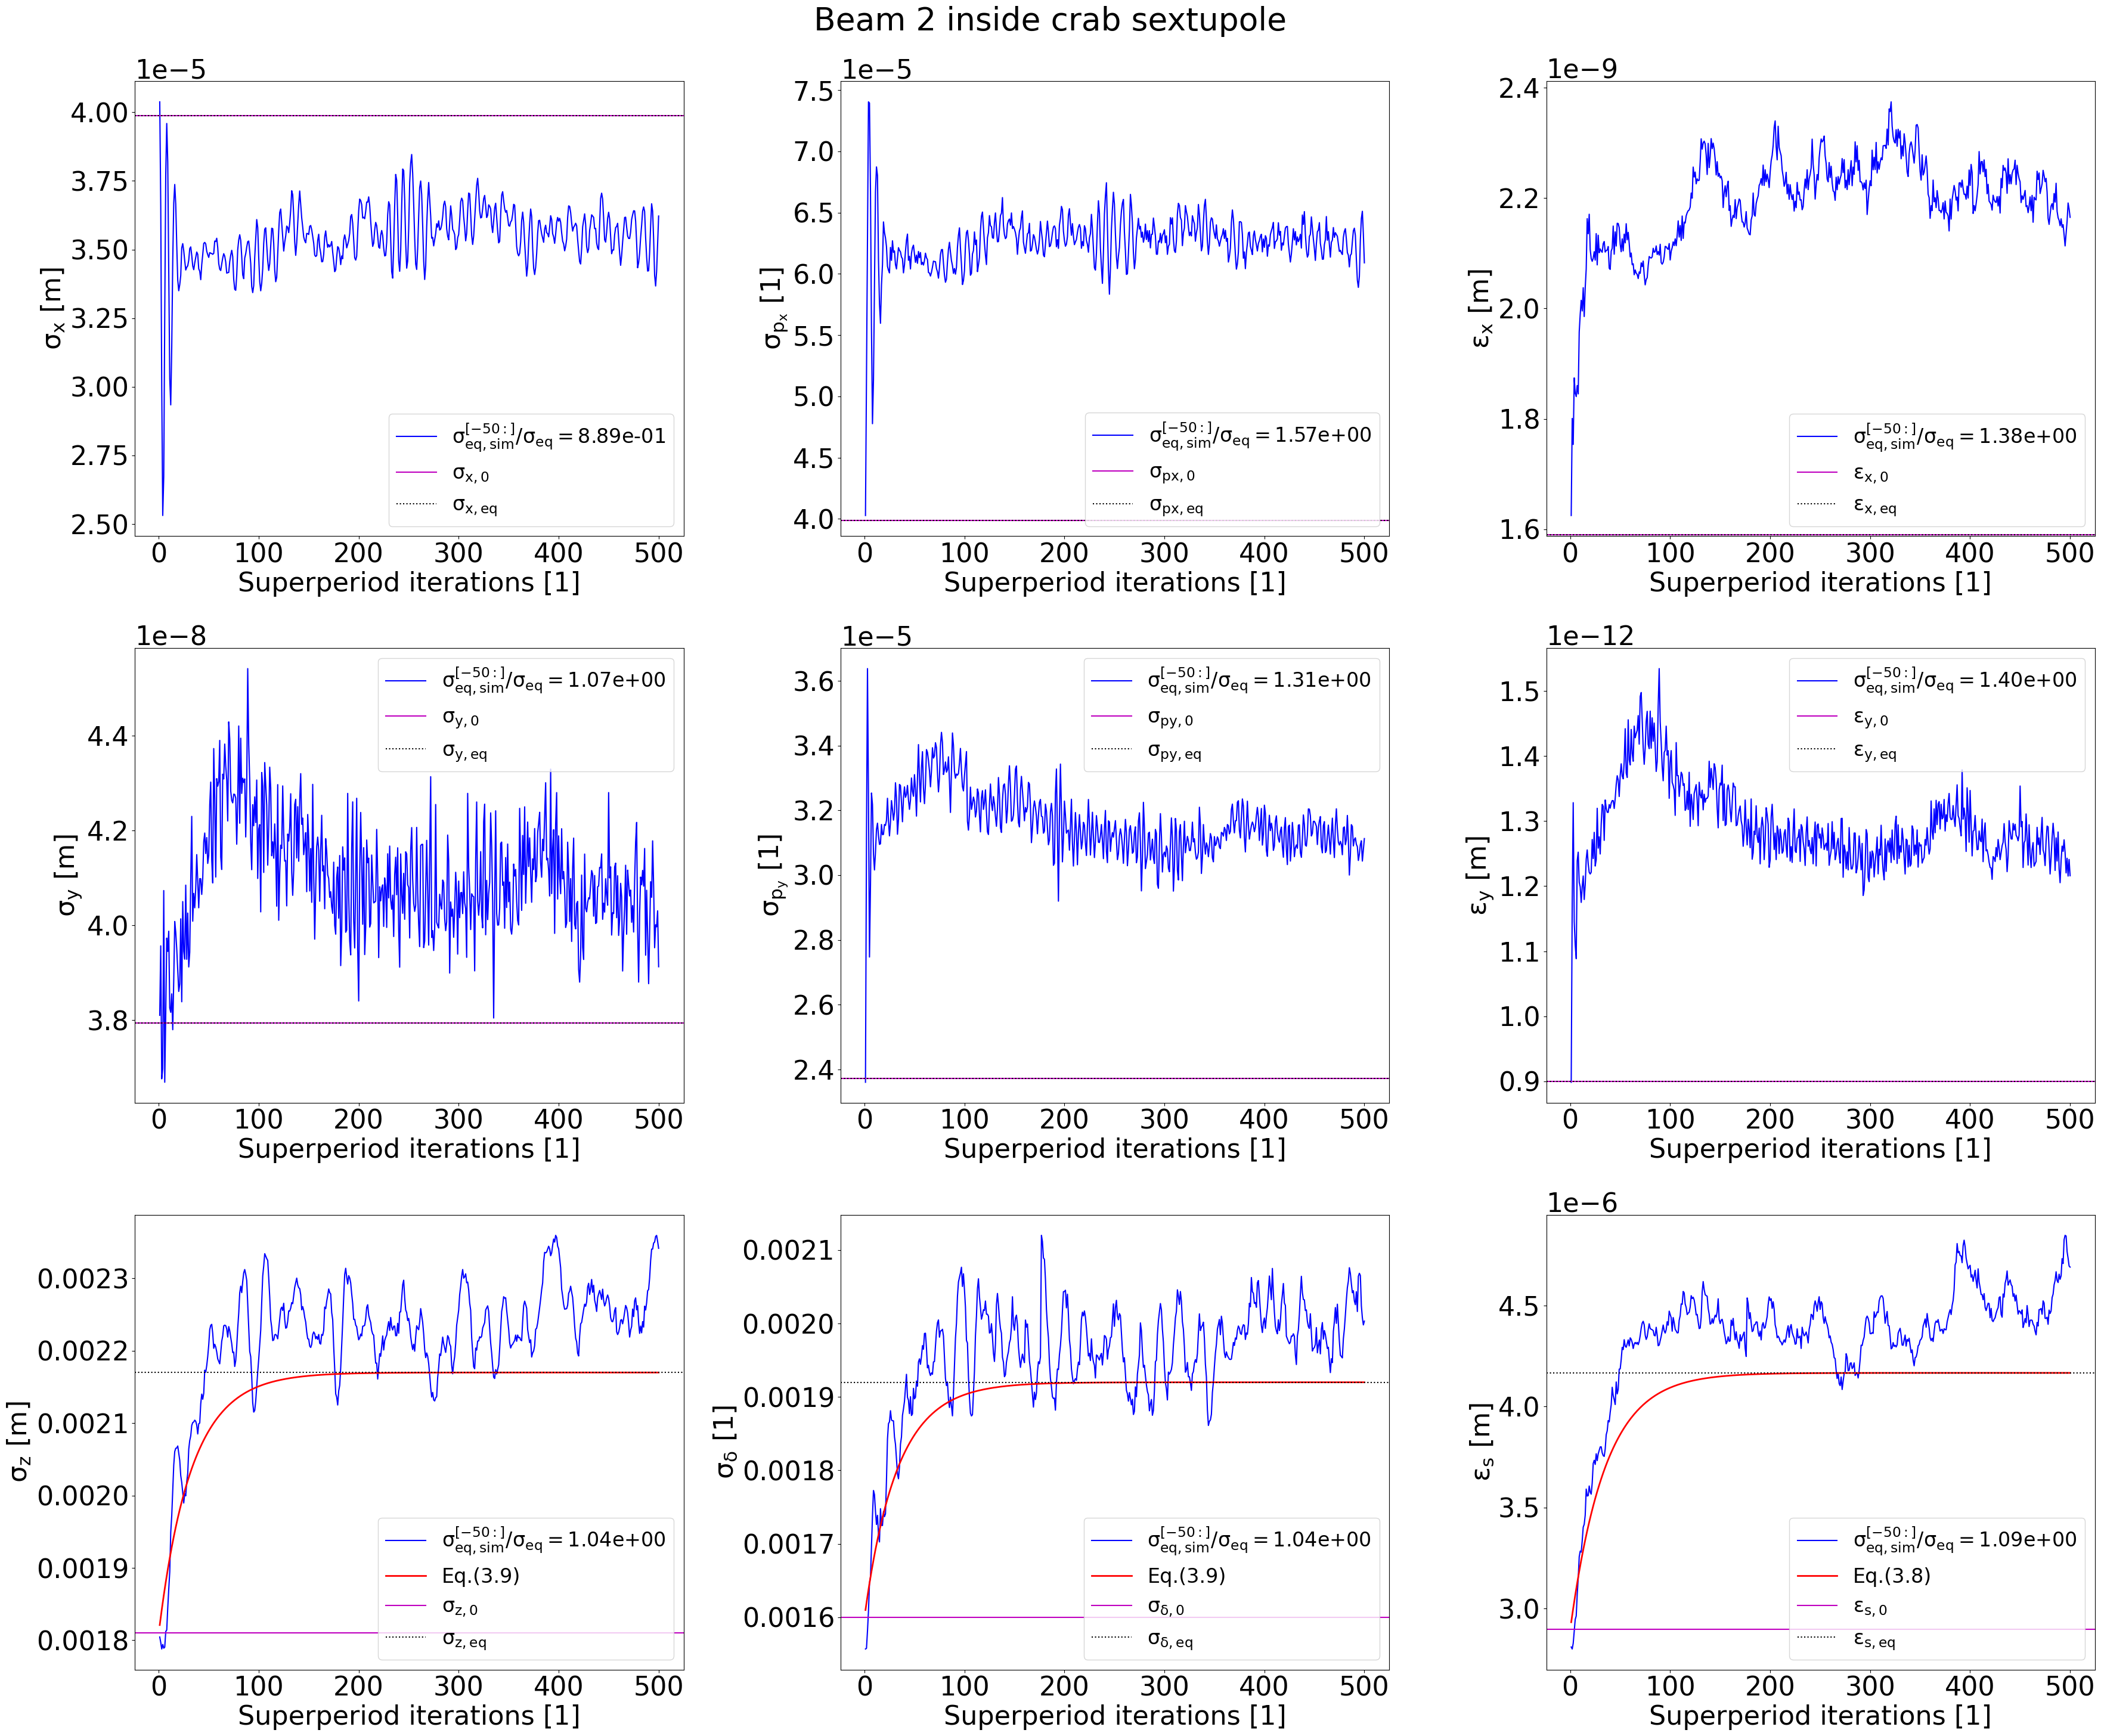

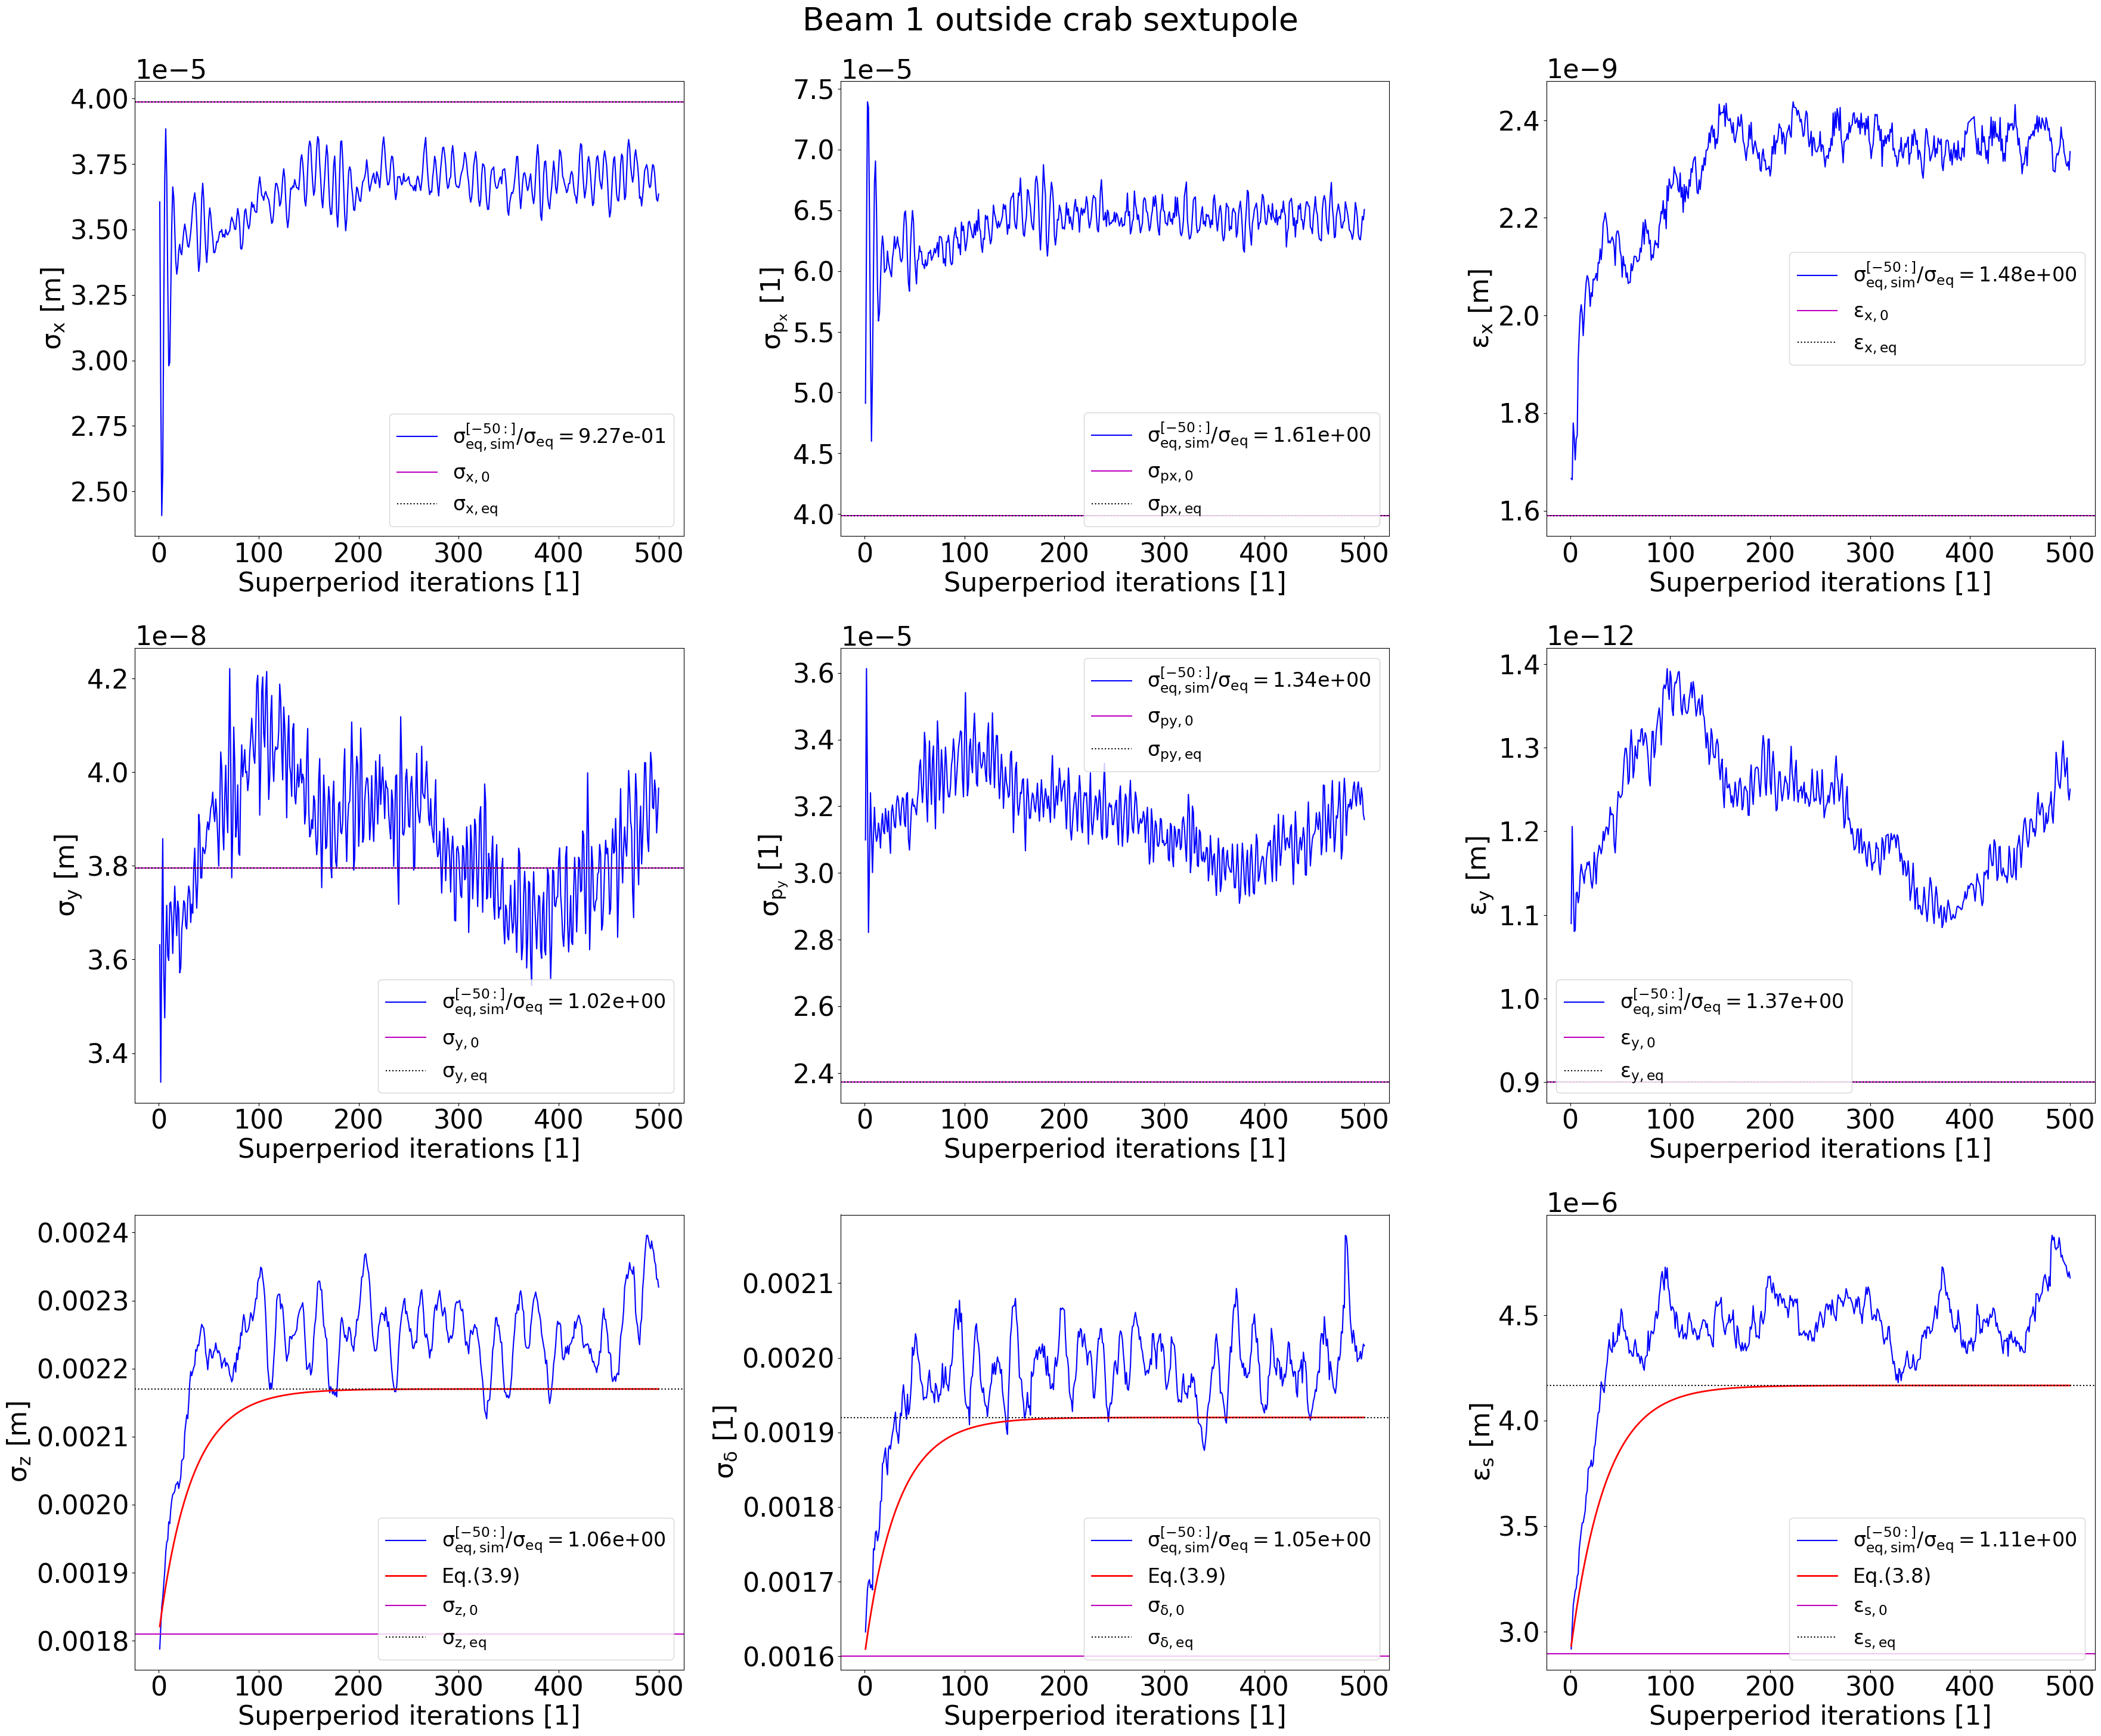

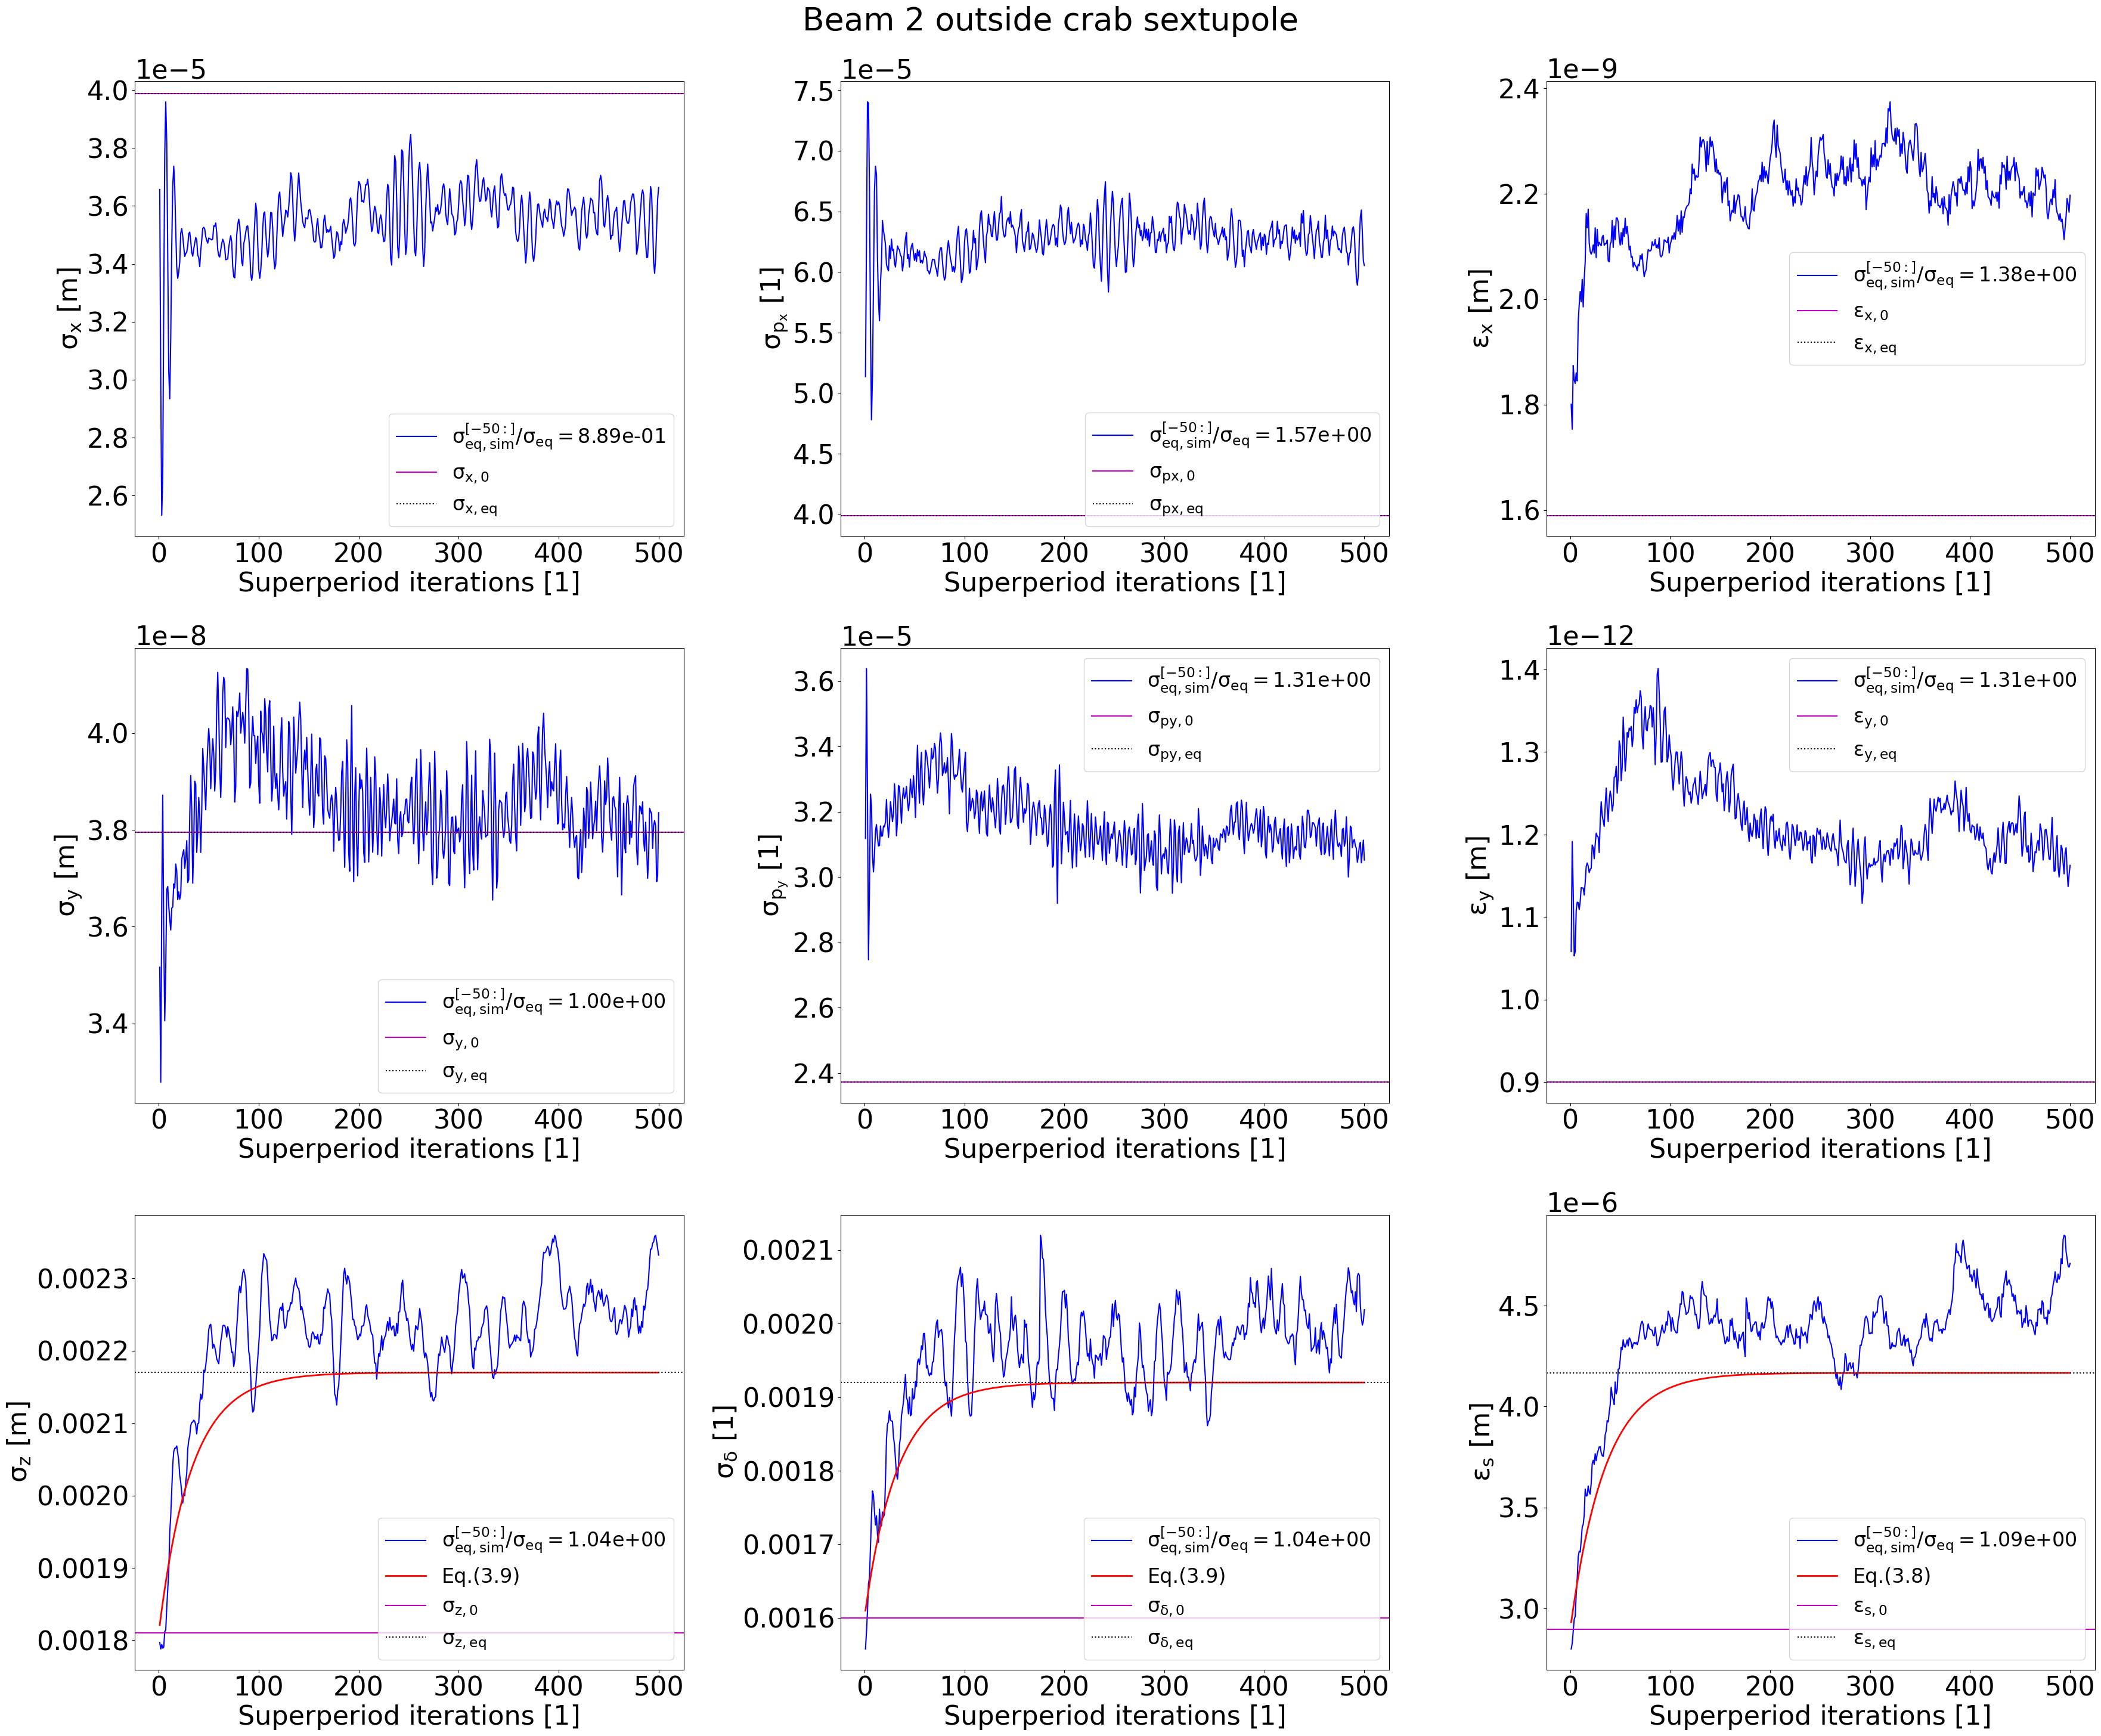

In [148]:
monitors = [monitor_coords_b1_1, monitor_coords_b2_1, monitor_coords_b1_2, monitor_coords_b2_2]
beta_x_at_mon = [beta_x, beta_x, beta_x_sext_right, beta_x_sext_left]
beta_y_at_mon = [beta_y, beta_y, beta_y_sext_right, beta_y_sext_left]
titles        = ["1 inside", "2 inside", "1 outside", "2 outside"]

for monitor_coords, beta_x_mon, beta_y_mon, title in zip(monitors, beta_x_at_mon, beta_y_at_mon, titles):
    coords_dict = monitor_coords.to_dict()["data"]
    
    x_arr_     = np.reshape(coords_dict[    "x"], (1000, n_turns))
    y_arr_     = np.reshape(coords_dict[    "y"], (1000, n_turns))
    z_arr      = np.reshape(coords_dict[ "zeta"], (1000, n_turns))
    px_arr_    = np.reshape(coords_dict[   "px"], (1000, n_turns))
    py_arr_    = np.reshape(coords_dict[   "py"], (1000, n_turns))
    delta_arr  = np.reshape(coords_dict["delta"], (1000, n_turns))
    
    # scale back to IP betas, using transfer matrix (alpha=0 here)
    if "outside" in title:
        x_arr     =  x_arr_ *    np.sqrt(beta_x/beta_x_mon) # this is bc Qx=0
        y_arr     = py_arr_ *    np.sqrt(beta_y*beta_y_mon) # this is bc Qy=pi/2
        px_arr    = px_arr_ *    np.sqrt(beta_x_mon/beta_x) 
        py_arr    =  y_arr_ * -1/np.sqrt(beta_y_mon*beta_y)
    else:
        x_arr  = x_arr_
        y_arr  = y_arr_
        px_arr = px_arr_
        py_arr = py_arr_
     
    x_co_arr     = np.mean(x_arr    , axis=0)    
    y_co_arr     = np.mean(y_arr    , axis=0)    
    z_co_arr     = np.mean(z_arr    , axis=0)    
    px_co_arr    = np.mean(px_arr   , axis=0)   
    py_co_arr    = np.mean(py_arr   , axis=0)   
    delta_co_arr = np.mean(delta_arr, axis=0)
    
    x_std_arr     = np.std(x_arr    , axis=0)    
    y_std_arr     = np.std(y_arr    , axis=0)    
    z_std_arr     = np.std(z_arr    , axis=0)    
    px_std_arr    = np.std(px_arr   , axis=0)   
    py_std_arr    = np.std(py_arr   , axis=0)   
    delta_std_arr = np.std(delta_arr, axis=0)
    
    emits_dict = coords_dict
    
    emit_x_arr = np.sqrt(np.mean(( x_arr -  np.mean(x_arr, axis=0))**2, axis=0) *\
                         np.mean((px_arr - np.mean(px_arr, axis=0))**2, axis=0) -\
                         np.mean(( x_arr -  np.mean(x_arr, axis=0)) *\
                                 (px_arr - np.mean(px_arr, axis=0)), axis=0)**2)
        
    emit_y_arr = np.sqrt(np.mean(( y_arr -  np.mean(y_arr, axis=0))**2, axis=0) *\
                         np.mean((py_arr - np.mean(py_arr, axis=0))**2, axis=0) -\
                         np.mean(( y_arr -  np.mean(y_arr, axis=0)) *\
                                 (py_arr - np.mean(py_arr, axis=0)), axis=0)**2)
        
    emit_s_arr = np.sqrt(np.mean((    z_arr - np.mean(    z_arr, axis=0))**2, axis=0) *\
                         np.mean((delta_arr - np.mean(delta_arr, axis=0))**2, axis=0) -\
                         np.mean((    z_arr - np.mean(    z_arr, axis=0)) *\
                                 (delta_arr - np.mean(delta_arr, axis=0)), axis=0)**2)
    
    ##################
    # plot evolution #
    ##################
    
    # this is used to compute simulated equilibrium from last w coordinates in legend
    w = 50
    
    turns_arr = np.linspace(1, n_turns, int(n_turns))
    
    fig, ax = plt.subplots(3,3, figsize=(36,30))
    
    # x, y, z
    ax[0,0].plot(turns_arr, x_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(x_std_arr[-w:])/sigma_x_eq:.2e}")
    ax[1,0].plot(turns_arr, y_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(y_std_arr[-w:])/sigma_y_eq:.2e}")
    ax[2,0].plot(turns_arr, z_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(z_std_arr[-w:])/sigma_z_eq_bs:.2e}")
    
    # px, py, delta
    ax[0,1].plot(turns_arr,    px_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(px_std_arr[-w:])/sigma_px_eq:.2e}")
    ax[1,1].plot(turns_arr,    py_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(py_std_arr[-w:])/sigma_py_eq:.2e}")
    ax[2,1].plot(turns_arr, delta_std_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(delta_std_arr[-w:])/sigma_delta_eq_bs:.2e}")
    
    # emittances
    ax[0,2].plot(turns_arr, emit_x_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_x_arr[-w:])/physemit_x_eq:.2e}")
    ax[1,2].plot(turns_arr, emit_y_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_y_arr[-w:])/physemit_y_eq:.2e}")
    ax[2,2].plot(turns_arr, emit_s_arr, c="b", label=f"$\mathrm{{\sigma_{{eq,sim}}^{{[-{w:d}:]}}/\sigma_{{eq}}}}=${np.mean(emit_s_arr[-w:])/physemit_s_eq_bs:.2e}")
    
    ###########################
    # plot analytical formula #
    ###########################
    
    sigma_z_fit     = np.sqrt((    sigma_z_init**2-    sigma_z_eq_bs**2) * np.exp(-emit_damping_rate_s*turns_arr) + sigma_z_eq_bs**2)
    sigma_delta_fit = np.sqrt((sigma_delta_init**2-sigma_delta_eq_bs**2) * np.exp(-emit_damping_rate_s*turns_arr) + sigma_delta_eq_bs**2)
    emit_s_fit      =         (    physemit_s_init-    physemit_s_eq_bs) * np.exp(-emit_damping_rate_s*turns_arr) + physemit_s_eq_bs
    
    # equation numbering in https://infoscience.epfl.ch/entities/publication/9f194f9b-76e8-4ba8-ab62-b19b17597ccc
    ax[2,0].plot(turns_arr,     sigma_z_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[2,1].plot(turns_arr, sigma_delta_fit, c="r", linewidth=2, label="Eq.(3.9)")
    ax[2,2].plot(turns_arr,      emit_s_fit, c="r", linewidth=2, label="Eq.(3.8)")
    
    ##############
    # plot lines #
    ##############
    
    ax[0,0].axhline(    sigma_x_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{x,0}}$")
    ax[1,0].axhline(    sigma_y_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{y,0}}$")
    ax[2,0].axhline(    sigma_z_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{z,0}}$")
    
    ax[0,1].axhline(   sigma_px_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{px,0}}$")
    ax[1,1].axhline(   sigma_py_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{py,0}}$")
    ax[2,1].axhline(sigma_delta_init, linestyle="-", c="m", label=r"$\mathrm{\sigma_{\delta,0}}$")
    
    ax[0,2].axhline( physemit_x_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{x,0}}$")
    ax[1,2].axhline( physemit_y_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{y,0}}$")
    ax[2,2].axhline( physemit_s_init, linestyle="-", c="m", label=r"$\mathrm{\varepsilon_{s,0}}$")
    
    ax[0,0].axhline(    sigma_x_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{x,eq}}$")
    ax[1,0].axhline(    sigma_y_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{y,eq}}$")
    ax[2,0].axhline(    sigma_z_eq_bs, linestyle=":", c="k", label=r"$\mathrm{\sigma_{z,eq}}$")
    
    ax[0,1].axhline(   sigma_px_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{px,eq}}$")
    ax[1,1].axhline(   sigma_py_eq, linestyle=":", c="k", label=r"$\mathrm{\sigma_{py,eq}}$")
    ax[2,1].axhline(sigma_delta_eq_bs, linestyle=":", c="k", label=r"$\mathrm{\sigma_{\delta,eq}}$")
    
    ax[0,2].axhline( physemit_x_eq, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{x,eq}}$")
    ax[1,2].axhline( physemit_y_eq, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{y,eq}}$")
    ax[2,2].axhline( physemit_s_eq_bs, linestyle=":", c="k", label=r"$\mathrm{\varepsilon_{s,eq}}$")
    
    #################
    # plot settings #
    #################
    
    ax[0,0].legend(fontsize=24)
    ax[1,0].legend(fontsize=24)
    ax[2,0].legend(fontsize=24)
    ax[0,1].legend(fontsize=24)
    ax[1,1].legend(fontsize=24)
    ax[2,1].legend(fontsize=24)
    ax[0,2].legend(fontsize=24)
    ax[1,2].legend(fontsize=24)
    ax[2,2].legend(fontsize=24)
    
    ax[0,0].set_xlabel("Superperiod iterations [1]")
    ax[1,0].set_xlabel("Superperiod iterations [1]")
    ax[2,0].set_xlabel("Superperiod iterations [1]")
    ax[0,1].set_xlabel("Superperiod iterations [1]")
    ax[1,1].set_xlabel("Superperiod iterations [1]")
    ax[2,1].set_xlabel("Superperiod iterations [1]")
    ax[0,2].set_xlabel("Superperiod iterations [1]")
    ax[1,2].set_xlabel("Superperiod iterations [1]")
    ax[2,2].set_xlabel("Superperiod iterations [1]")
    
    ax[0,0].set_ylabel(r"$\mathrm{\sigma_{x}}$ [m]")
    ax[1,0].set_ylabel(r"$\mathrm{\sigma_{y}}$ [m]")
    ax[2,0].set_ylabel(r"$\mathrm{\sigma_{z}}$ [m]")
    ax[0,1].set_ylabel(r"$\mathrm{\sigma_{p_x}}$ [1]")
    ax[1,1].set_ylabel(r"$\mathrm{\sigma_{p_y}}$ [1]")
    ax[2,1].set_ylabel(r"$\mathrm{\sigma_{\delta}}$ [1]")
    ax[0,2].set_ylabel(r"$\mathrm{\varepsilon_{x}}$ [m]")
    ax[1,2].set_ylabel(r"$\mathrm{\varepsilon_{y}}$ [m]")
    ax[2,2].set_ylabel(r"$\mathrm{\varepsilon_{s}}$ [m]")
    
    fig.suptitle(f"Beam {title} crab sextupole")
    fig.tight_layout()